In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [24]:
train_data = pd.read_csv("../house price/train.csv")
test_data = pd.read_csv("../house price/test.csv")
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 外れ値除去

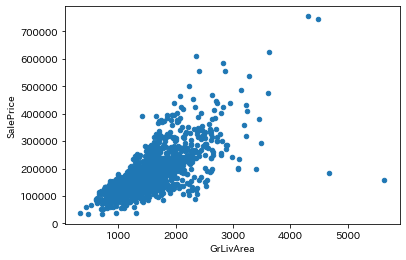

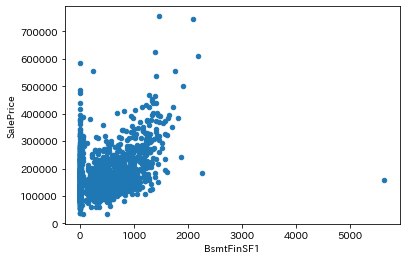

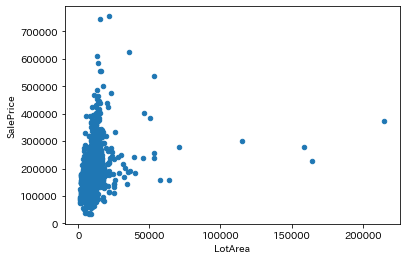

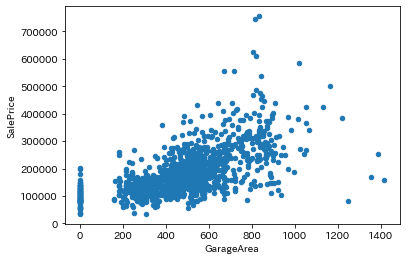

In [25]:
for i in ['GrLivArea', 'BsmtFinSF1', 'LotArea', 'GarageArea']:
    train_data.plot.scatter(x=i, y='SalePrice')

plt.show()

In [26]:
train_data = train_data.drop(train_data[(train_data.GrLivArea > 4000) & (train_data.SalePrice < 300000)].index)
train_data = train_data.drop(train_data[(train_data.BsmtFinSF1 > 4000)].index)
train_data = train_data.drop(train_data[(train_data.LotArea > 150000)].index)
train_data = train_data.drop(train_data[(train_data.GarageArea > 1200) & (train_data.SalePrice < 300000)].index)

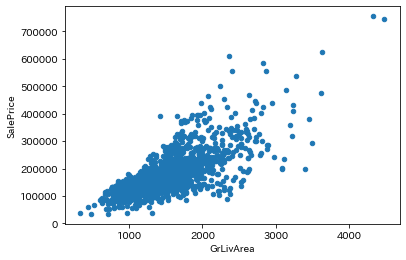

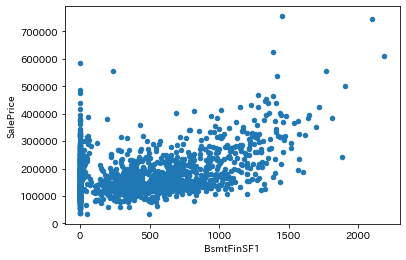

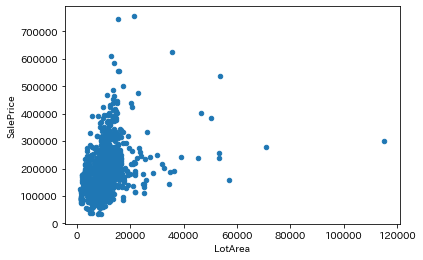

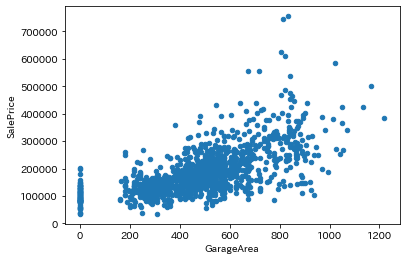

In [27]:
for i in ['GrLivArea', 'BsmtFinSF1', 'LotArea', 'GarageArea']:
    train_data.plot.scatter(x=i, y='SalePrice')

plt.show()

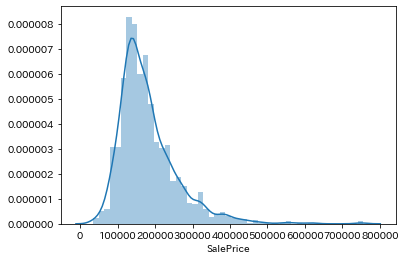

In [28]:
sns.distplot(train_data['SalePrice'])

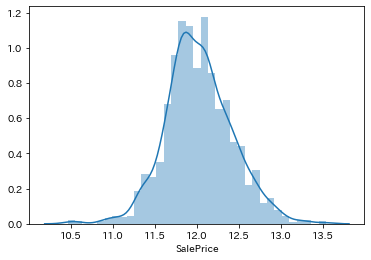

In [29]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data.SalePrice)

In [30]:
Id = test_data['Id']
train_y = train_data.SalePrice.values

all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice','Id'], axis=1, inplace=True)
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2907,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2908,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2909,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## 欠損値処理

In [31]:
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
print(missing_ratio)
all_data[missing_ratio.index]

MSZoning         0.137410
LotFrontage     16.592236
Alley           93.198214
Utilities        0.068705
Exterior1st      0.034352
Exterior2nd      0.034352
MasVnrType       0.824459
MasVnrArea       0.790106
BsmtQual         2.782549
BsmtCond         2.816901
BsmtExposure     2.816901
BsmtFinType1     2.713844
BsmtFinSF1       0.034352
BsmtFinType2     2.748196
BsmtFinSF2       0.034352
BsmtUnfSF        0.034352
TotalBsmtSF      0.034352
Electrical       0.034352
BsmtFullBath     0.068705
BsmtHalfBath     0.068705
KitchenQual      0.034352
Functional       0.068705
FireplaceQu     48.746135
GarageType       5.393336
GarageYrBlt      5.462041
GarageFinish     5.462041
GarageCars       0.034352
GarageArea       0.034352
GarageQual       5.462041
GarageCond       5.462041
PoolQC          99.690828
Fence           80.384748
MiscFeature     96.496049
SaleType         0.034352
dtype: float64


,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
1,RL,80.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
2,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
3,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,None,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
4,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,RM,21.0,NaN,AllPub,CemntBd,CmentBd,None,0.0,TA,TA,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,WD
2907,RM,21.0,NaN,AllPub,CemntBd,CmentBd,None,0.0,TA,TA,...,1970.0,Unf,1.0,286.0,TA,TA,NaN,NaN,NaN,WD
2908,RL,160.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,TA,TA,...,1960.0,Unf,2.0,576.0,TA,TA,NaN,NaN,NaN,WD
2909,RL,62.0,NaN,AllPub,HdBoard,Wd Shng,None,0.0,Gd,TA,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,MnPrv,Shed,WD


In [32]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# LotFrontageは慎重に扱いたいとのこと。ちなみに道路にどれくらいの面しているか。
# Neighborhoodとの相関係数は0.4くらいなのになぜこれでくくったんだろうか？

In [33]:
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']

In [34]:
for i in mode_fill_li:
    all_data[i].fillna(all_data[i].mode()[0], inplace=True)

for j in None_fill_li:
    all_data[j].fillna('None',inplace=True)

for k in fill_0_li:
    all_data[k].fillna(0, inplace=True)

In [54]:
all_data.to_csv('all_data.csv')

In [36]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2907,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2908,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2909,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## データの準備

In [107]:
all_data = pd.read_csv('../house price/all_data.csv')
all_data = all_data.iloc[:,1:]
train = all_data[:len(train_data)]
test = all_data[len(train_data):]

from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = all_data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

categorical_cols = list(all_data.select_dtypes(include=['object']).columns)
train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

train_x = train
print(train_x.shape, train_y.shape)

(1452, 79) (1452,)


In [108]:
train_x

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2,3,3,0,4,...,0,0,3,4,4,0,2,2008,8,4
1,20,3,80.0,9600,1,2,3,3,0,2,...,0,0,3,4,4,0,5,2007,8,4
2,60,3,68.0,11250,1,2,0,3,0,4,...,0,0,3,4,4,0,9,2008,8,4
3,70,3,60.0,9550,1,2,0,3,0,0,...,0,0,3,4,4,0,2,2006,8,0
4,60,3,84.0,14260,1,2,0,3,0,2,...,0,0,3,4,4,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,60,3,62.0,7917,1,2,3,3,0,4,...,0,0,3,4,4,0,8,2007,8,4
1448,20,3,85.0,13175,1,2,3,3,0,4,...,0,0,3,2,4,0,2,2010,8,4
1449,70,3,66.0,9042,1,2,3,3,0,4,...,0,0,3,0,2,2500,5,2010,8,4
1450,20,3,68.0,9717,1,2,3,3,0,4,...,0,0,3,4,4,0,4,2010,8,4


## バリデーション

In [116]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, train_y, scoring='neg_mean_squared_error', cv=kf))
    return (rmse)

## モデリング

In [117]:
model = lgb.LGBMRegressor(objective='regression',
                          num_leaves=5,
                          learning_rate=0.05,
                          n_estimators=720,
                          max_bin = 55, 
                          bagging_fraction = 0.8,
                          bagging_freq = 5, 
                          feature_fraction = 0.2319,
                          feature_fraction_seed=9, 
                          bagging_seed=9,
                          min_data_in_leaf =6, 
                          min_sum_hessian_in_leaf = 11)

score = rmse_cv(model)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1169 (0.0057)



In [111]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [113]:
model.fit(train_x, train_y)
train_prediction = model.predict(train)
prediction = np.expm1(model.predict(test.values))
print(rmsle(train_y, train_prediction))

0.0725062195016152


In [72]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': prediction})
sub.to_csv('sub_lgb_reg_1.csv', index=False)
# 0.12325

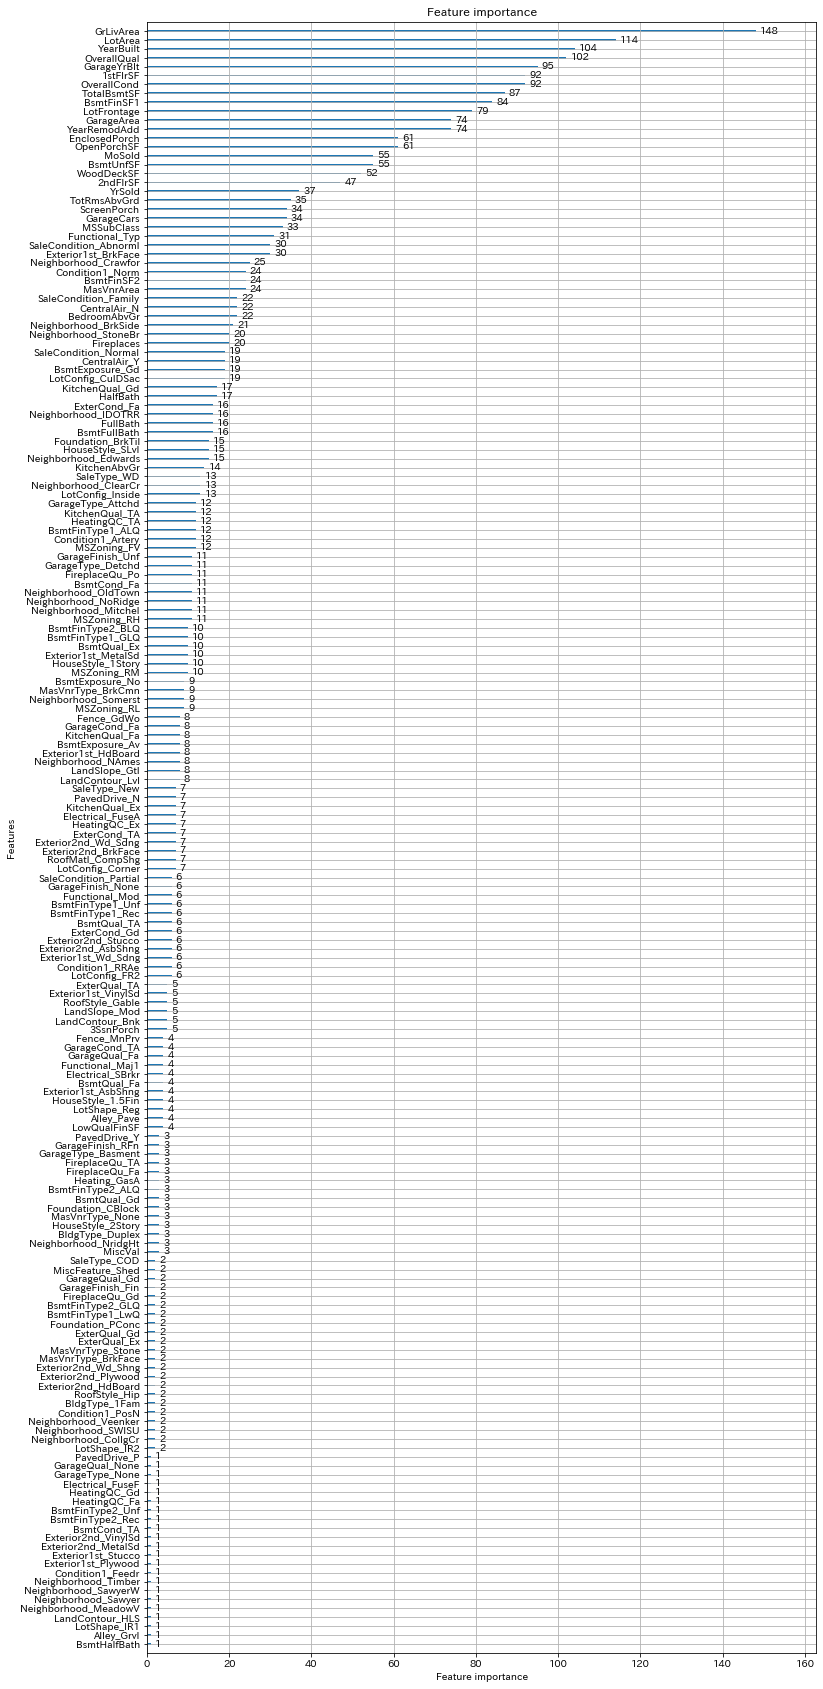

In [23]:
lgb.plot_importance(model, figsize=(12, 30))

## 普通のlightgbmだとどうなる？

In [133]:
all_data = import_data('../house price/all_data.csv')
all_data.iloc[:,1:]
import re
all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
categorical_cols = list(all_data.select_dtypes(include=['category']).columns)
print(categorical_cols)

Memory usage of dataframe is 1.78 MB
Memory usage after optimization is: 0.32 MB
Decreased by 82.2%
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [134]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = all_data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test
train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

In [135]:
X_train = train
y_train = train_y
X_test = test

In [136]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {'objective':'regression',
          'metric': 'rmse',
          'num_leaves':5,
          'learning_rate':0.05,
          'n_estimators':720,
          'max_bin' : 55, 
          'bagging_fraction' : 0.8,
          'bagging_freq' : 5, 
          'feature_fraction' : 0.2319,
          'feature_fraction_seed':9, 
          'bagging_seed':9,
          'min_data_in_leaf' :6, 
          'min_sum_hessian_in_leaf' : 11,
          'importance_type': 'gain'
}

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)
   
    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importance()
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)

    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')
# 関数化

C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299159	valid_1's rmse: 0.322309
[20]	training's rmse: 0.239496	valid_1's rmse: 0.260742
[30]	training's rmse: 0.200187	valid_1's rmse: 0.217914
[40]	training's rmse: 0.173739	valid_1's rmse: 0.191606
[50]	training's rmse: 0.15447	valid_1's rmse: 0.171988
[60]	training's rmse: 0.141401	valid_1's rmse: 0.158744
[70]	training's rmse: 0.13215	valid_1's rmse: 0.14946
[80]	training's rmse: 0.125324	valid_1's rmse: 0.143775
[90]	training's rmse: 0.119873	valid_1's rmse: 0.138294
[100]	training's rmse: 0.115436	valid_1's rmse: 0.13494
[110]	training's rmse: 0.11201	valid_1's rmse: 0.132558
[120]	training's rmse: 0.109164	valid_1's rmse: 0.130546
[130]	training's rmse: 0.1068	valid_1's rmse: 0.129652
[140]	training's rmse: 0.104947	valid_1's rmse: 0.128556
[150]	training's rmse: 0.103439	valid_1's rmse: 0.127743
[160]	training's rmse: 0.101897	valid_1's rmse: 0.127197
[170]	training's rmse: 0.100268	valid_1's r

In [137]:
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

CV: 0.11924944244185788


In [138]:
feat_df

,Feature_fold1,Importance_fold1,Feature_fold2,Importance_fold2,Feature_fold3,Importance_fold3,Feature_fold4,Importance_fold4,Feature_fold5,Importance_fold5
0,Unnamed0,4,Unnamed0,16,Unnamed0,7,Unnamed0,28,Unnamed0,27
1,MSSubClass,0,MSSubClass,9,MSSubClass,6,MSSubClass,14,MSSubClass,8
2,MSZoning,2,MSZoning,4,MSZoning,0,MSZoning,4,MSZoning,2
3,LotFrontage,11,LotFrontage,19,LotFrontage,16,LotFrontage,39,LotFrontage,40
4,LotArea,44,LotArea,38,LotArea,45,LotArea,66,LotArea,60
...,...,...,...,...,...,...,...,...,...,...
75,MiscVal,1,MiscVal,3,MiscVal,1,MiscVal,1,MiscVal,2
76,MoSold,6,MoSold,18,MoSold,3,MoSold,43,MoSold,29
77,YrSold,1,YrSold,11,YrSold,2,YrSold,10,YrSold,27
78,SaleType,0,SaleType,0,SaleType,0,SaleType,6,SaleType,4


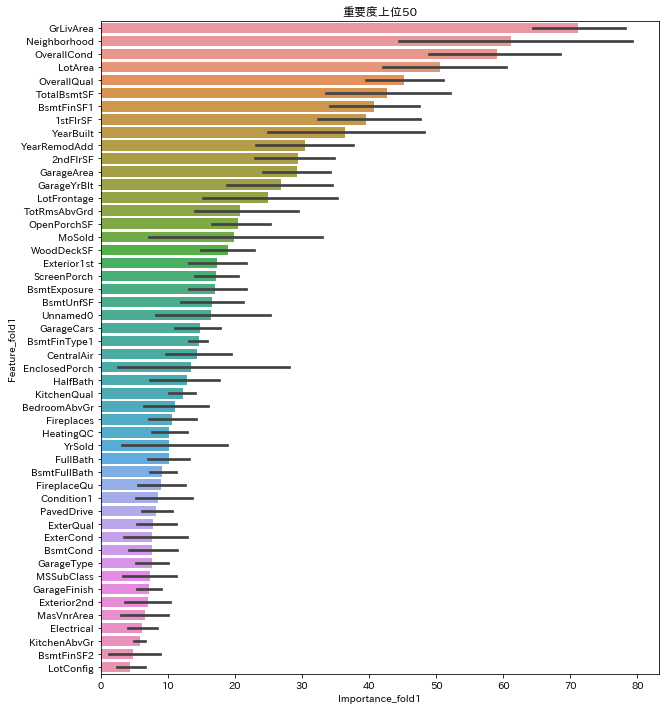

In [145]:
def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    feat = pd.concat([a, b, c, d, e]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)["Feature_fold1"].values
    plt.figure(figsize=(10,12))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices[:50])
feature_importance_plot(feat_df)

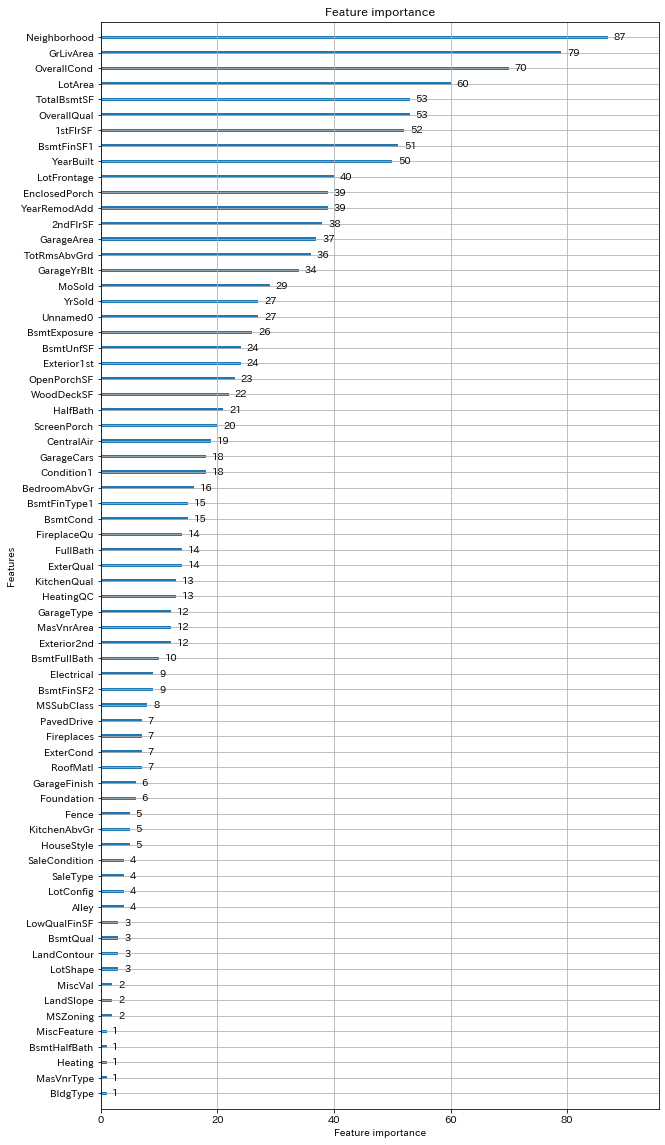

In [101]:
lgb.plot_importance(model, figsize=(10,20))

In [102]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)
# 0.12986